# Problem 1: Determine the Ground State Structures for the Two Phases 

NOTICE TO BINDER USERS: YOUR NOTEBOOK PROGRESS WILL NOT BE SAVED IF YOU CLOSE THIS WINDOW OR LEAVE IT INACTIVE FOR TOO LONG.

PLEASE DOWNLOAD YOUR NOTEBOOKS AND FILES REGULARLY OR DOWNLOAD THIS REPO AND RUN OFFLINE ON YOUR MACHINE. See "running_offline.md" for more info.

## Part A&B: VASP Input Files 

First, we need to prepare a POSCAR for the diamond cubic structure. To do this, we'll import some classes from the [pymatgen](http://pymatgen.org/) library for python, which is written and maintained by the Materials Project.

In [25]:
from pymatgen import Structure, Lattice, PeriodicSite
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

Now we'll create a lattice for DC silicon.

The diamond cubic structure can be thought of as two interpenetrating face centered cubic (FCC) lattices (Let's start by defining the lattice in the more familiar interpenetrating FCC basis and then simplify it to the primitive unit cell with pymatgen. The coordinates of the atoms in the DC structure are (in terms of the lattice vectors):


$\big[ 0, 0, 0 \big]$, 
$\big[ \frac{1}{4}, \frac{1}{4}, \frac{1}{4} \big]$, 
$\big[ \frac{1}{2}, \frac{1}{2}, 0 \big]$, 
$\big[ \frac{1}{2}, 0, \frac{1}{2}\big]$, 
$\big[ 0, \frac{1}{2}, \frac{1}{2}\big]$,
$\big[ \frac{1}{4}, \frac{3}{4}, \frac{3}{4} \big]$, 
$\big[ \frac{3}{4}, \frac{1}{4}, \frac{3}{4} \big]$, 
$\big[ \frac{3}{4}, \frac{3}{4}, \frac{1}{4} \big]$


In [26]:
# Define the lattice parameter, in Å
lattice_parameter = 5.43

# Create a cubic lattice with the lattice parameter above
cubic_lattice = Lattice.cubic(lattice_parameter)

# Create a list of coordinates (i.e. [[x, y, z], [x2, y2, z2], ...])
DC_coordinates =[[0,0,0],[1/4,1/4,1/4],[1/2,1/2,0],[1/2,0,1/2],[0,1/2,1/2],[1/4,3/4,3/4],[3/4,1/4,3/4],[3/4,3/4,1/4]]

DC_species = ["Si" for coord in DC_coordinates] # creates the list of Si species used when creating the Structure

# Create the structure
Si_DC = Structure(cubic_lattice, species=DC_species, coords=DC_coordinates ) # creates the Structure

# Simplify the structure to a primitive one
Si_DC = SpacegroupAnalyzer(Si_DC).get_primitive_standard_structure()

When you enter "`print(Si_DC)`", you should get something that looks similar to the following (sites may be in different order):

```
Full Formula (Si2)
Reduced Formula: Si
abc   :   3.839590   3.839590   3.839590
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Si    0     0     0
  1  Si    0.25  0.25  0.25
  ```

In [27]:
print(Si_DC)

Full Formula (Si2)
Reduced Formula: Si
abc   :   3.839590   3.839590   3.839590
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Si    0     0     0
  1  Si    0.25  0.25  0.25


Now, we need to prepare our VASP input files.

First, let's import [Kpoints](http://pymatgen.org/pymatgen.io.vasp.inputs.html#pymatgen.io.vasp.inputs.Kpoints), [Incar](http://pymatgen.org/pymatgen.io.vasp.inputs.html#pymatgen.io.vasp.inputs.Incar), [Potcar](http://pymatgen.org/pymatgen.io.vasp.inputs.html#pymatgen.io.vasp.inputs.Potcar),  and [Pocar](http://pymatgen.org/pymatgen.io.vasp.inputs.html#pymatgen.io.vasp.inputs.Poscar) from *pymatgen* and then write some code to prepare a structure optimization calculation. We'll start off defining where we want everything saved and write a POTCAR corresonding to a PBE calculation of Si there.

In [28]:
from pymatgen.io.vasp.inputs import Kpoints, Poscar, Potcar, Incar

# This is how you create a POTCAR. However, if you don't have access 
# to the VASP pseudopotentials, this command may not work
POTCAR = Potcar("Si", functional="PBE")

ValueError: No POTCAR for S with functional PBE found. Please set the PMG_VASP_PSP_DIR environment in .pmgrc.yaml, or you may need to set PMG_DEFAULT_FUNCTIONAL to PBE_52 or PBE_54 if you are using newer psps from VASP.

Now lets use the Poscar class to create a POSCAR file for the DC-Si structure we just wrote.

In [29]:
POSCAR = Poscar(Si_DC)
print(POSCAR)

Si2
1.0
0.000000 2.715000 2.715000
2.715000 0.000000 2.715000
2.715000 2.715000 0.000000
Si
2
direct
0.000000 0.000000 0.000000 Si
0.250000 0.250000 0.250000 Si



Similarly, we can create a KPOINTS file with the Kpoints class...

In [30]:
# fill in this tuple with desired grid dimensions (e.g. (a, b, c))
grid = (6,6,6)

# We're using the gamma_automatic constructor here to create a grid centered at Gamma.
KPOINTS = Kpoints.monkhorst_automatic(kpts=grid)

print(KPOINTS)

Automatic kpoint scheme
0
Monkhorst
6 6 6



Now let's create an INCAR file. We could do that by editing the example file directly, but let's do it with code instead so we can automate that process later.

In [36]:
my_incar_params = {"EDIFF" : 0.0004, 
                "EDIFFG" : -0.01, 
                "ENCUT" : 250,
                "IBRION": 2, 
                "ISIF" : 3, 
                "ISMEAR" : 0, 
                "SIGMA" : 0.2 , 
                "NSW" : 15,
                "NBANDS" : 8,
                "LREAL" : 'False'}

In [37]:
INCAR = Incar.from_dict(my_incar_params)
print(INCAR)

EDIFF = 0.0004
EDIFFG = -0.01
ENCUT = 250
IBRION = 2
ISIF = 3
ISMEAR = 0
LREAL = False
NBANDS = 8
NSW = 15
SIGMA = 0.2



In [38]:
def write_input_set(POTCAR, POSCAR, INCAR, KPOINTS, directory="new_input_set", use_fake_potcar=True):
    
    import os
    if not os.path.exists(directory):
        os.makedirs(directory)

    if not use_fake_potcar:
        POTCAR.write_file("{}/POTCAR".format(directory))
    else:
        from shutil import copyfile
        # Copy over a fake potcar
        copyfile("fake_vasp_data/3kvi0H85jC/POTCAR", "directory")
    
    POSCAR.write_file("{}/POSCAR".format(directory))
    INCAR.write_file("{}/INCAR".format(directory))
    KPOINTS.write_file("{}/KPOINTS".format(directory))
    print("Input set written to '{}'".format(directory))

Okay, let's write these to our directory and then run fake_vasp on it!

In [39]:
# Directory where you want to save the files. e.g. "my_part_1/Si_DC"
my_directory = 'my_part_1/Si_DC'

write_input_set(None, POSCAR, INCAR, KPOINTS, directory=my_directory)

Input set written to 'my_part_1/Si_DC'


In [40]:
!python fake_vasp.py my_part_1/Si_DC

 running on    8 total cores
 distrk:  each k-point on    8 cores,    1 groups
 distr:  one band on    1 cores,    8 groups
 using from now: INCAR     
 vasp.5.4.4.18Apr17-6-g9f103f2a35 (build Dec 09 2018 21:25:21) complex          
  
 POSCAR found type information on POSCAR  Si
 POSCAR found :  1 types and       2 ions
 scaLAPACK will be used

 ----------------------------------------------------------------------------- 
|                                                                             |
|           W    W    AA    RRRRR   N    N  II  N    N   GGGG   !!!           |
|           W    W   A  A   R    R  NN   N  II  NN   N  G    G  !!!           |
|           W    W  A    A  R    R  N N  N  II  N N  N  G       !!!           |
|           W WW W  AAAAAA  RRRRR   N  N N  II  N  N N  G  GGG   !            |
|           WW  WW  A    A  R   R   N   NN  II  N   NN  G    G                |
|           W    W  A    A  R    R  N    N  II  N    N   GGGG   !!!           |
|           

You should see some new files written to the directory you ran fake_vasp in.

In [41]:
!ls my_part_1/Si_DC

'ls' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


You can get the final energy of the converged structure using pymatgen's Outcar class (example below).

In [42]:
from pymatgen.io.vasp.outputs import Outcar
OUTCAR = Outcar(my_directory + "/OUTCAR")
OUTCAR.final_energy

-10.82792015

We can now repeat the same process for the $\beta$-Sn structure. Note we only have to prepare a new POSCAR for this. 

In [43]:
# Define the lattice parameters, in Å
lattice_parameter_a = 4.9
lattice_parameter_c = 2.548

# Create the tetragonal lattice
tetragonal_lattice = Lattice.tetragonal(lattice_parameter_a, lattice_parameter_c)

# Create a list of coordinates (i.e. [ [x1, y1, z1], [x2, y2, z2], ... ])
BSn_coordinates = [[0,0,0],[1/2,1/2,1/2],[0,1/2,3/4],[1/2,0,1/4]] 

BSn_species = ["Si" for coord in BSn_coordinates] # creates the list of Si species used when creating the Structure

Si_BSn = Structure(tetragonal_lattice, species=BSn_species, coords=BSn_coordinates ) # creates the Structure,

In [51]:
my_directory = "my_part_1/Sn"

POSCAR = Poscar(Si_BSn)

write_input_set(None, POSCAR, INCAR, KPOINTS, directory=my_directory)

Input set written to 'my_part_1/Sn'


Okay, now let's run fake_vasp on the BSn input files!

In [45]:
!python fake_vasp.py my_part_1/Sn

 running on    8 total cores
 distrk:  each k-point on    8 cores,    1 groups
 distr:  one band on    1 cores,    8 groups
 using from now: INCAR     
 vasp.5.4.4.18Apr17-6-g9f103f2a35 (build Dec 09 2018 21:25:21) complex          
  
 POSCAR found type information on POSCAR  Si
 POSCAR found :  1 types and       2 ions
 scaLAPACK will be used

 ----------------------------------------------------------------------------- 
|                                                                             |
|           W    W    AA    RRRRR   N    N  II  N    N   GGGG   !!!           |
|           W    W   A  A   R    R  NN   N  II  NN   N  G    G  !!!           |
|           W    W  A    A  R    R  N N  N  II  N N  N  G       !!!           |
|           W WW W  AAAAAA  RRRRR   N  N N  II  N  N N  G  GGG   !            |
|           WW  WW  A    A  R   R   N   NN  II  N   NN  G    G                |
|           W    W  A    A  R    R  N    N  II  N    N   GGGG   !!!           |
|           

## Part C: Convergence tests

For the convergence tests, we'll need to repeatedly run VASP using different input parameters. Let's start by combining the code we wrote above into a function that writes the input files we need given a structure, ENCUT value, and number of KPOINTS. We'll also include a helper function to make plotting the convergence curves easier.

In [46]:
def make_convergence_calc(structure, ENCUT, n_kpoints, output_dir, incar_params, use_fake_potcar=True):
    if not use_fake_potcar:
        # make POTCAR
        POTCAR = Potcar(["Si"], functional="PBE")
    else:
        POTCAR = None
    
    # make POSCAR from primitive unit cell of structure
    POSCAR = Poscar(SpacegroupAnalyzer(structure).get_primitive_standard_structure())
    
    # make KPOINTS from specified number of kpoints (n,n,n)
    grid = (n_kpoints, n_kpoints, n_kpoints)
    KPOINTS = Kpoints.monkhorst_automatic(kpts=grid)
    
    # Use our previous incar settings as starting point
    incar_params = dict(incar_params) # make a copy so we don't mutate original dict
    incar_params["ENCUT"] = ENCUT
    INCAR = Incar.from_dict(incar_params)
    
    # Write our input set to the directory
    write_input_set(POTCAR, POSCAR, INCAR, KPOINTS, directory=output_dir)
    
    
import matplotlib.pyplot as plt
from math import log

# Helper function to plot convergence test data.
def plot_convergence(parameters, energies, xlabel="Cutoff Energy, $E_{cut} $ (eV)", 
                     ylabel="Final Energy (eV/atom)", title="Final Energy vs Cutoff Energy",
                     save_fig=False, filename="DC_ENCUT_conv.png"):
    """Helper function to create convergence plots. 
    
    Arguments:
        parameters (list of int/float): independent variable (e.g. ENCUT or KPOINTS)
        energies (list of float): resulting final energies
        xlabel (str): label for the x-axis
        ylabel (str): label for you y-axis
        title (str): title for the plot
        save_fig (bool): if True, figure is saved as a picture
        filename (str): filename of picture
        """
    
    # plot the data
    plt.plot(parameters, energies, 'rx')
    plt.plot(parameters, energies, 'b-')
    
    # add labels to the plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    # saves the plot in convergence_test_results/plots/ (WILL OVERWRITE FILES IF FILENAME IS NOT CHANGED)
    if save_fig:
        plt.savefig("convergence_test_results/plots/DC_ENCUT_conv.png", bbox_inches='tight')
    # show the plot here
    plt.show()
    

Below is an example of how to use this function. We define two lists (one of the parameter we changed and one of the final energies returned by VASP) and then provide those to the function as input arguments.

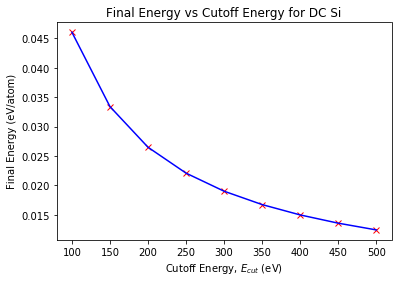

In [47]:
example_ENCUTS = [100, 150, 200, 250, 300, 350, 400, 450, 500]
example_energies = [log(i)/i for i in example_ENCUTS]

# Example usage for plot_convergence
plot_convergence(example_ENCUTS, example_energies, 
                 xlabel="Cutoff Energy, $E_{cut} $ (eV)", 
                 ylabel="Final Energy (eV/atom)", 
                 title = "Final Energy vs Cutoff Energy for DC Si")

Okay, let's create some convergence tests!

Input set written to 'convergence_tests/DC/E_150_K_6'
Input set written to 'convergence_tests/DC/E_200_K_6'
Input set written to 'convergence_tests/DC/E_250_K_6'
Input set written to 'convergence_tests/DC/E_300_K_6'
Input set written to 'convergence_tests/DC/E_350_K_6'
 running on    8 total cores
 distrk:  each k-point on    8 cores,    1 groups
 distr:  one band on    1 cores,    8 groups
 using from now: INCAR     
 vasp.5.4.4.18Apr17-6-g9f103f2a35 (build Dec 09 2018 21:25:21) complex          
  
 POSCAR found type information on POSCAR  Si
 POSCAR found :  1 types and       2 ions
 scaLAPACK will be used

 ----------------------------------------------------------------------------- 
|                                                                             |
|           W    W    AA    RRRRR   N    N  II  N    N   GGGG   !!!           |
|           W    W   A  A   R    R  NN   N  II  NN   N  G    G  !!!           |
|           W    W  A    A  R    R  N N  N  II  N N  N  G     

 WAVECAR not read
 entering main loop
       N       E                     dE             d eps       ncg     rms          rms(c)
DAV:   1     0.228732528105E+01    0.22873E+01   -0.25241E+03   456   0.520E+02
DAV:   2    -0.108434880306E+02   -0.13131E+02   -0.12766E+02   696   0.676E+01
DAV:   3    -0.110175946075E+02   -0.17411E+00   -0.17411E+00   560   0.960E+00
DAV:   4    -0.110181259421E+02   -0.53133E-03   -0.53133E-03   736   0.595E-01
DAV:   5    -0.110181265927E+02   -0.65057E-06   -0.65056E-06   568   0.134E-02    0.301E+00
DAV:   6    -0.108936619634E+02    0.12446E+00   -0.82305E-02   528   0.149E+00    0.178E+00
DAV:   7    -0.108368201664E+02    0.56842E-01   -0.15127E-01   584   0.215E+00    0.154E-01
DAV:   8    -0.108381297041E+02   -0.13095E-02   -0.40971E-03   512   0.474E-01    0.252E-02
DAV:   9    -0.108382226827E+02   -0.92979E-04   -0.96810E-05   408   0.794E-02
   1 F= -.10838223E+02 E0= -.10838209E+02  d E =-.108382E+02
 curvature:   0.00 expect dE= 0.000E+

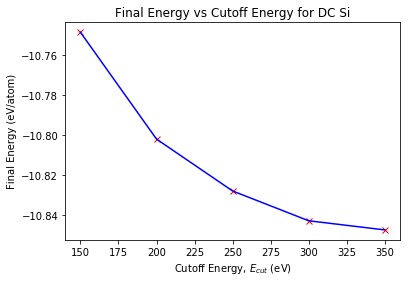

In [48]:
# list of ENCUT values (e.g. [ENCUT_1, ENCUT_2, ...])
Ecs = [150,200,250,300,350] 

# writes the ENCUT convergence test input sets to convergence_tests/DC/
for E in Ecs:
    dirname = "convergence_tests/DC/E_{}_K_{}".format(E, 6)
# We're using a (6,6,6) k-points grid for this convergence test
    make_convergence_calc(Si_DC, E, 6, output_dir=dirname, incar_params=my_incar_params)
    
!python fake_vasp.py "convergence_tests/DC/E_150_K_6"
!python fake_vasp.py "convergence_tests/DC/E_200_K_6"
!python fake_vasp.py "convergence_tests/DC/E_250_K_6"
!python fake_vasp.py "convergence_tests/DC/E_300_K_6"
!python fake_vasp.py "convergence_tests/DC/E_350_K_6"

from pymatgen.io.vasp.outputs import Outcar

#create a list to store the directories
DirList = []
for E in Ecs:
    DirList.append("convergence_tests/DC/E_{}_K_{}".format(E, 6))

print(DirList)

finalEnergies = []
for dir in DirList:
    OUTCAR = Outcar(dir + "/OUTCAR")
    finalEnergies.append(OUTCAR.final_energy)

print(finalEnergies)

plot_convergence(Ecs, finalEnergies, 
                 xlabel="Cutoff Energy, $E_{cut} $ (eV)", 
                 ylabel="Final Energy (eV/atom)", 
                 title = "Final Energy vs Cutoff Energy for DC Si")
    
    
    
 

Input set written to 'convergence_tests/DC/E_350_K_2'
Input set written to 'convergence_tests/DC/E_350_K_3'
Input set written to 'convergence_tests/DC/E_350_K_4'
Input set written to 'convergence_tests/DC/E_350_K_5'
Input set written to 'convergence_tests/DC/E_350_K_6'
Input set written to 'convergence_tests/DC/E_350_K_7'
Input set written to 'convergence_tests/DC/E_350_K_8'
Input set written to 'convergence_tests/DC/E_350_K_9'
Input set written to 'convergence_tests/DC/E_350_K_10'
Input set written to 'convergence_tests/DC/E_350_K_11'
Input set written to 'convergence_tests/DC/E_350_K_12'
 running on    8 total cores
 distrk:  each k-point on    8 cores,    1 groups
 distr:  one band on    1 cores,    8 groups
 using from now: INCAR     
 vasp.5.4.4.18Apr17-6-g9f103f2a35 (build Dec 09 2018 21:25:21) complex          
  
 POSCAR found type information on POSCAR  Si
 POSCAR found :  1 types and       2 ions
 scaLAPACK will be used

 ------------------------------------------------------

|      on modern multi-core architectures or massively parallel machines.     |
|      Do your own testing !!!!                                               |
|      Unfortunately you need to use the default for GW and RPA calculations. |
|      (for HF NCORE is supported but not extensively tested yet)             |
|                                                                             |
 ----------------------------------------------------------------------------- 

 LDA part: xc-table for Pade appr. of Perdew
 POSCAR, INCAR and KPOINTS ok, starting setup
 FFT: planning ...
 WAVECAR not read
 entering main loop
       N       E                     dE             d eps       ncg     rms          rms(c)
DAV:   1     0.333561038245E+01    0.33356E+01   -0.27568E+03   168   0.584E+02
DAV:   2    -0.108141001148E+02   -0.14150E+02   -0.13503E+02   280   0.719E+01
DAV:   3    -0.109671007797E+02   -0.15300E+00   -0.15300E+00   176   0.978E+00
DAV:   4    -0.109678534499E+02   -0.75

DAV:   4    -0.108451387207E+02    0.10531E-04   -0.53923E-05   568   0.674E-02
   2 F= -.10845139E+02 E0= -.10845126E+02  d E =-.258619E-02
 trial-energy change:   -0.002586  1 .order   -0.002964   -0.017248    0.011319
 step:   0.6038(harm=  0.6038)  dis= 0.00000  next Energy=   -10.847759 (dE=-0.521E-02)
 bond charge predicted
       N       E                     dE             d eps       ncg     rms          rms(c)
DAV:   1    -0.108485627431E+02   -0.34135E-02   -0.42262E-02  1160   0.116E+00    0.131E-01
DAV:   2    -0.108478550035E+02    0.70774E-03   -0.59371E-04  1296   0.162E-01    0.750E-02
DAV:   3    -0.108474908571E+02    0.36415E-03   -0.74580E-04   744   0.139E-01
   3 F= -.10847491E+02 E0= -.10847475E+02  d E =-.493832E-02
 curvature:  -0.30 expect dE=-0.429E-05 dE for cont linesearch -0.429E-05
 trial: gam= 0.00000 g(F)=  0.999E-46 g(S)=  0.142E-04 ort =-0.495E-03 (trialstep = 0.921E+00)
 search vector abs. value=  0.142E-04
 reached required accuracy - stopping stru

|      NCORE specifies how many cores store one orbital (NPAR=cpu/NCORE).     |
|      This setting can  greatly improve the performance of VASP for DFT.     |
|      The default,   NCORE=1            might be grossly inefficient         |
|      on modern multi-core architectures or massively parallel machines.     |
|      Do your own testing !!!!                                               |
|      Unfortunately you need to use the default for GW and RPA calculations. |
|      (for HF NCORE is supported but not extensively tested yet)             |
|                                                                             |
 ----------------------------------------------------------------------------- 

 LDA part: xc-table for Pade appr. of Perdew
 POSCAR, INCAR and KPOINTS ok, starting setup
 FFT: planning ...
 WAVECAR not read
 entering main loop
       N       E                     dE             d eps       ncg     rms          rms(c)
DAV:   1     0.485350819380E+01    0.48

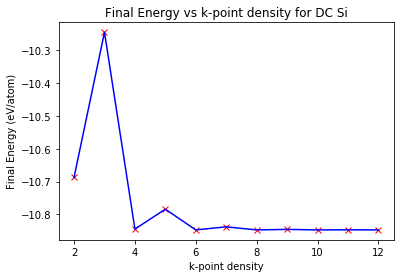

In [49]:
# ENCUT value determined from last convergence test
ENCUT = 350

# list of KPOINTS densities (n, n, n) (e.g. [k1, k2,, k3, ...])
Ks = [2,3,4,5,6,7,8,9,10,11,12]

# write the KPOINTS convergence test input sets to convergence_tests/DC/
for K in Ks:
    dirname = "convergence_tests/DC/E_{}_K_{}".format(ENCUT, K)
    make_convergence_calc(Si_DC, E, K, output_dir=dirname, incar_params=my_incar_params)
!python fake_vasp.py "convergence_tests/DC/E_350_K_2"
!python fake_vasp.py "convergence_tests/DC/E_350_K_3"
!python fake_vasp.py "convergence_tests/DC/E_350_K_4"
!python fake_vasp.py "convergence_tests/DC/E_350_K_5"
!python fake_vasp.py "convergence_tests/DC/E_350_K_6"
!python fake_vasp.py "convergence_tests/DC/E_350_K_7"
!python fake_vasp.py "convergence_tests/DC/E_350_K_8"
!python fake_vasp.py "convergence_tests/DC/E_350_K_9"
!python fake_vasp.py "convergence_tests/DC/E_350_K_10"
!python fake_vasp.py "convergence_tests/DC/E_350_K_11"
!python fake_vasp.py "convergence_tests/DC/E_350_K_12"

from pymatgen.io.vasp.outputs import Outcar

#create a list to store the directories
kList = []
for K in Ks:
    kList.append("convergence_tests/DC/E_{}_K_{}".format(ENCUT, K))

print(kList)

finalEnergies = []
for k in kList:
    OUTCAR = Outcar(k + "/OUTCAR")
    finalEnergies.append(OUTCAR.final_energy)

print(finalEnergies)

plot_convergence(Ks, finalEnergies, 
                 xlabel="k-point density", 
                 ylabel="Final Energy (eV/atom)", 
                 title = "Final Energy vs k-point density for DC Si")




Now, after you have run fake_vasp in all of these directories (or used a script you wrote to do so) prepare the lists of ENCUT values and final energies and us them to plot the convergence curves.

Input set written to 'convergence_tests/BSn/E_150_K_6'
Input set written to 'convergence_tests/BSn/E_200_K_6'
Input set written to 'convergence_tests/BSn/E_250_K_6'
Input set written to 'convergence_tests/BSn/E_300_K_6'
Input set written to 'convergence_tests/BSn/E_350_K_6'
 running on    8 total cores
 distrk:  each k-point on    8 cores,    1 groups
 distr:  one band on    1 cores,    8 groups
 using from now: INCAR     
 vasp.5.4.4.18Apr17-6-g9f103f2a35 (build Dec 09 2018 21:25:21) complex          
  
 POSCAR found type information on POSCAR  Si
 POSCAR found :  1 types and       2 ions
 scaLAPACK will be used

 ----------------------------------------------------------------------------- 
|                                                                             |
|           W    W    AA    RRRRR   N    N  II  N    N   GGGG   !!!           |
|           W    W   A  A   R    R  NN   N  II  NN   N  G    G  !!!           |
|           W    W  A    A  R    R  N N  N  II  N N  N  G

|           W    W  A    A  R    R  N N  N  II  N N  N  G       !!!           |
|           W WW W  AAAAAA  RRRRR   N  N N  II  N  N N  G  GGG   !            |
|           WW  WW  A    A  R   R   N   NN  II  N   NN  G    G                |
|           W    W  A    A  R    R  N    N  II  N    N   GGGG   !!!           |
|                                                                             |
|      For optimal performance we recommend to set                            |
|        NCORE= 4 - approx SQRT( number of cores)                             |
|      NCORE specifies how many cores store one orbital (NPAR=cpu/NCORE).     |
|      This setting can  greatly improve the performance of VASP for DFT.     |
|      The default,   NCORE=1            might be grossly inefficient         |
|      on modern multi-core architectures or massively parallel machines.     |
|      Do your own testing !!!!                                               |
|      Unfortunately you need to use the

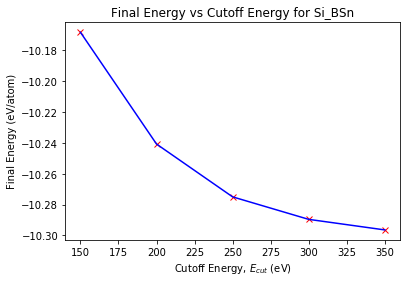

In [50]:
# list of ENCUT values (e.g. [ENCUT_1, ENCUT_2, ...])
Ecs = [150,200,250,300,350] 

# writes the ENCUT convergence test input sets to convergence_tests/DC/
for E in Ecs:
    dirname = "convergence_tests/BSn/E_{}_K_{}".format(E, 6)
# We're using a (6,6,6) k-points grid for this convergence test
    make_convergence_calc(Si_BSn, E, 6, output_dir=dirname, incar_params=my_incar_params)
    
!python fake_vasp.py "convergence_tests/BSn/E_150_K_6"
!python fake_vasp.py "convergence_tests/BSn/E_200_K_6"
!python fake_vasp.py "convergence_tests/BSn/E_250_K_6"
!python fake_vasp.py "convergence_tests/BSn/E_300_K_6"
!python fake_vasp.py "convergence_tests/BSn/E_350_K_6"

from pymatgen.io.vasp.outputs import Outcar

#create a list to store the directories
DirList = []
for E in Ecs:
    DirList.append("convergence_tests/BSn/E_{}_K_{}".format(E, 6))

print(DirList)

finalEnergies = []
for dir in DirList:
    OUTCAR = Outcar(dir + "/OUTCAR")
    finalEnergies.append(OUTCAR.final_energy)

print(finalEnergies)

plot_convergence(Ecs, finalEnergies, 
                 xlabel="Cutoff Energy, $E_{cut} $ (eV)", 
                 ylabel="Final Energy (eV/atom)", 
                 title = "Final Energy vs Cutoff Energy for Si_BSn")


Input set written to 'convergence_tests/BSn/E_350_K_2'
Input set written to 'convergence_tests/BSn/E_350_K_3'
Input set written to 'convergence_tests/BSn/E_350_K_4'
Input set written to 'convergence_tests/BSn/E_350_K_5'
Input set written to 'convergence_tests/BSn/E_350_K_6'
Input set written to 'convergence_tests/BSn/E_350_K_7'
Input set written to 'convergence_tests/BSn/E_350_K_8'
Input set written to 'convergence_tests/BSn/E_350_K_9'
Input set written to 'convergence_tests/BSn/E_350_K_10'
Input set written to 'convergence_tests/BSn/E_350_K_11'
Input set written to 'convergence_tests/BSn/E_350_K_12'
 running on    8 total cores
 distrk:  each k-point on    8 cores,    1 groups
 distr:  one band on    1 cores,    8 groups
 using from now: INCAR     
 vasp.5.4.4.18Apr17-6-g9f103f2a35 (build Dec 09 2018 21:25:21) complex          
  
 POSCAR found type information on POSCAR  Si
 POSCAR found :  1 types and       2 ions
 scaLAPACK will be used

 -------------------------------------------

 ZBRENT: interpolating
 opt :   0.5811  next Energy=   -10.174035 (dE=-0.162E+00)
 bond charge predicted
       N       E                     dE             d eps       ncg     rms          rms(c)
DAV:   1    -0.101740395593E+02   -0.41216E-05   -0.68845E-05    48   0.489E-02    0.380E-03
DAV:   2    -0.101740393116E+02    0.24774E-06   -0.29487E-06    48   0.146E-02
   5 F= -.10174039E+02 E0= -.10160724E+02  d E =-.161626E+00
 curvature:  -0.22 expect dE=-0.407E-03 dE for cont linesearch -0.172E-05
 ZBRENT: bisectioning
 opt :   0.5791  next Energy=   -10.174043 (dE=-0.162E+00)
 bond charge predicted
       N       E                     dE             d eps       ncg     rms          rms(c)
DAV:   1    -0.101740437674E+02   -0.42081E-05   -0.44983E-05    48   0.399E-02    0.397E-03
DAV:   2    -0.101740433586E+02    0.40880E-06   -0.17303E-06    48   0.110E-02
   6 F= -.10174043E+02 E0= -.10160728E+02  d E =-.161630E+00
 curvature:  -0.52 expect dE=-0.915E-03 dE for cont linesearch -0

       N       E                     dE             d eps       ncg     rms          rms(c)
DAV:   1    -0.103668434190E+02   -0.76116E-05   -0.30209E-05    88   0.334E-02    0.406E-03
DAV:   2    -0.103668431770E+02    0.24199E-06   -0.10413E-06    88   0.872E-03
  15 F= -.10366843E+02 E0= -.10355987E+02  d E =-.639580E-03
 curvature:  -0.22 expect dE=-0.979E-05 dE for cont linesearch -0.322E-05
 ZBRENT: bisectioning
 opt :   0.5553  next Energy=   -10.366846 (dE=-0.642E-03)
 writing wavefunctions
 running on    8 total cores
 distrk:  each k-point on    8 cores,    1 groups
 distr:  one band on    1 cores,    8 groups
 using from now: INCAR     
 vasp.5.4.4.18Apr17-6-g9f103f2a35 (build Dec 09 2018 21:25:21) complex          
  
 POSCAR found type information on POSCAR  Si
 POSCAR found :  1 types and       2 ions
 scaLAPACK will be used

 ----------------------------------------------------------------------------- 
|                                                                   

|                                                                             |
|           W    W    AA    RRRRR   N    N  II  N    N   GGGG   !!!           |
|           W    W   A  A   R    R  NN   N  II  NN   N  G    G  !!!           |
|           W    W  A    A  R    R  N N  N  II  N N  N  G       !!!           |
|           W WW W  AAAAAA  RRRRR   N  N N  II  N  N N  G  GGG   !            |
|           WW  WW  A    A  R   R   N   NN  II  N   NN  G    G                |
|           W    W  A    A  R    R  N    N  II  N    N   GGGG   !!!           |
|                                                                             |
|      For optimal performance we recommend to set                            |
|        NCORE= 4 - approx SQRT( number of cores)                             |
|      NCORE specifies how many cores store one orbital (NPAR=cpu/NCORE).     |
|      This setting can  greatly improve the performance of VASP for DFT.     |
|      The default,   NCORE=1           

DAV:   1    -0.102722715550E+02   -0.74035E-05   -0.83552E-05   448   0.524E-02    0.482E-03
DAV:   2    -0.102722710385E+02    0.51647E-06   -0.31637E-06   448   0.149E-02
   7 F= -.10272271E+02 E0= -.10263040E+02  d E =-.630320E-01
 curvature:  -0.03 expect dE=-0.330E-05 dE for cont linesearch -0.581E-06
 ZBRENT: interpolating
 opt :   1.8934  next Energy=   -10.272284 (dE=-0.630E-01)
 bond charge predicted
       N       E                     dE             d eps       ncg     rms          rms(c)
DAV:   1    -0.102722724442E+02   -0.88920E-06   -0.32337E-06   448   0.108E-02    0.132E-03
DAV:   2    -0.102722723974E+02    0.46823E-07   -0.16530E-07   448   0.341E-03
   8 F= -.10272272E+02 E0= -.10263037E+02  d E =-.630333E-01
 curvature:  -0.01 expect dE=-0.802E-06 dE for cont linesearch -0.935E-07
 ZBRENT: interpolating
 opt :   1.8929  next Energy=   -10.272284 (dE=-0.630E-01)
 bond charge predicted
       N       E                     dE             d eps       ncg     rms       

 trial: gam= 0.36197 g(F)=  0.712E-49 g(S)=  0.437E-02 ort = 0.699E-03 (trialstep = 0.160E+01)
 search vector abs. value=  0.621E-02
 bond charge predicted
       N       E                     dE             d eps       ncg     rms          rms(c)
DAV:   1    -0.102682452905E+02   -0.33645E-02   -0.30687E-01  2272   0.323E+00    0.336E-01
DAV:   2    -0.102653864793E+02    0.28588E-02   -0.52882E-03  1976   0.560E-01    0.196E-01
DAV:   3    -0.102637282197E+02    0.16583E-02   -0.30616E-03  2168   0.312E-01    0.185E-02
DAV:   4    -0.102637279781E+02    0.24165E-06   -0.80563E-05   880   0.717E-02
   5 F= -.10263728E+02 E0= -.10255694E+02  d E =0.118891E-02
 trial-energy change:    0.001189  1 .order    0.001451   -0.007411    0.010313
 step:   0.6697(harm=  0.6697)  dis= 0.00000  next Energy=   -10.266466 (dE=-0.155E-02)
 bond charge predicted
       N       E                     dE             d eps       ncg     rms          rms(c)
DAV:   1    -0.102682567476E+02   -0.45285E-02   

|           WW  WW  A    A  R   R   N   NN  II  N   NN  G    G                |
|           W    W  A    A  R    R  N    N  II  N    N   GGGG   !!!           |
|                                                                             |
|      For optimal performance we recommend to set                            |
|        NCORE= 4 - approx SQRT( number of cores)                             |
|      NCORE specifies how many cores store one orbital (NPAR=cpu/NCORE).     |
|      This setting can  greatly improve the performance of VASP for DFT.     |
|      The default,   NCORE=1            might be grossly inefficient         |
|      on modern multi-core architectures or massively parallel machines.     |
|      Do your own testing !!!!                                               |
|      Unfortunately you need to use the default for GW and RPA calculations. |
|      (for HF NCORE is supported but not extensively tested yet)             |
|                                       

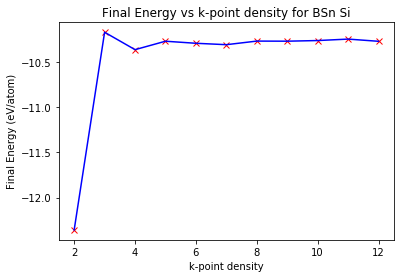

In [53]:
# ENCUT value determined from last convergence test
ENCUT = 350

# list of KPOINTS densities (n, n, n) (e.g. [k1, k2,, k3, ...])
Ks = [2,3,4,5,6,7,8,9,10,11,12]

# write the KPOINTS convergence test input sets to convergence_tests/DC/
for K in Ks:
    dirname = "convergence_tests/BSn/E_{}_K_{}".format(ENCUT, K)
    make_convergence_calc(Si_BSn, E, K, output_dir=dirname, incar_params=my_incar_params)
!python fake_vasp.py "convergence_tests/BSn/E_350_K_2"
!python fake_vasp.py "convergence_tests/BSn/E_350_K_3"
!python fake_vasp.py "convergence_tests/BSn/E_350_K_4"
!python fake_vasp.py "convergence_tests/BSn/E_350_K_5"
!python fake_vasp.py "convergence_tests/BSn/E_350_K_6"
!python fake_vasp.py "convergence_tests/BSn/E_350_K_7"
!python fake_vasp.py "convergence_tests/BSn/E_350_K_8"
!python fake_vasp.py "convergence_tests/BSn/E_350_K_9"
!python fake_vasp.py "convergence_tests/BSn/E_350_K_10"
!python fake_vasp.py "convergence_tests/BSn/E_350_K_11"
!python fake_vasp.py "convergence_tests/BSn/E_350_K_12"

from pymatgen.io.vasp.outputs import Outcar

#create a list to store the directories
kList = []
for K in Ks:
    kList.append("convergence_tests/BSn/E_{}_K_{}".format(ENCUT, K))

print(kList)

finalEnergies = []
for k in kList:
    OUTCAR = Outcar(k + "/OUTCAR")
    finalEnergies.append(OUTCAR.final_energy)

print(finalEnergies)

plot_convergence(Ks, finalEnergies, 
                 xlabel="k-point density", 
                 ylabel="Final Energy (eV/atom)", 
                 title = "Final Energy vs k-point density for BSn Si")